In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno
sns.set_style("darkgrid")

import matplotlib as mpl

mpl.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["font.size"] = 10

import os
import gc

os.chdir("./제6회 L.POINT Big Data Competition/")

def trans_time_info(df):
    try:
        df["time"] = pd.to_datetime(df.sess_dt.astype(str) +" "+df.hit_tm)
    except AttributeError:
        df["time"] = pd.to_datetime(df.de_dt.astype(str)+" "+df.de_tm)
        
    df['year'] = df.time.dt.year
    df['month'] = df.time.dt.month
    df['day'] = df.time.dt.day
    df['weekday'] = df.time.dt.weekday
    df["hour"] = df.time.dt.hour
    df["min"] = df.time.dt.minute
    
    return df

def resumetable(df):
    print(f"DataSet Shape : {df.shape}")
    summary = pd.DataFrame(df.dtypes, columns={'dtypes'})
    summary = summary.reset_index()
    summary["Name"] = summary["index"]
    summary = summary[["Name","dtypes"]]
    summary['Missing'] = df.isnull().sum().values
    summary['Unique'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values
    
    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, "Entropy"] = round(stats.entropy(df[name].value_counts(normalize = True), base=2),2)
        
    return summary

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

from IPython.core.display import HTML

def multi_table(table_list):
    ''' Acceps a list of IpyTable objects and returns a table which contains each IpyTable in a cell
    '''
    return HTML(
        '<table><tr style="background-color:white;">' + 
        ''.join(['<td>' + table._repr_html_() + '</td>' for table in table_list]) +
        '</tr></table>'
    )

In [82]:
online_df = pd.read_csv("제6회 L.POINT Big Data Competition-분석용데이터-01.온라인 행동 정보.csv")
trans_df = pd.read_csv("제6회 L.POINT Big Data Competition-분석용데이터-02.거래 정보.csv")
cust_df = pd.read_csv("제6회 L.POINT Big Data Competition-분석용데이터-03.고객 Demographic 정보.csv")
item_df = pd.read_csv("제6회 L.POINT Big Data Competition-분석용데이터-04.상품분류 정보.csv")

c:\python37\lib\site-packages\IPython\core\interactiveshell.py:2718: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [97]:
online_df = trans_time_info(online_df)
trans_df = trans_time_info(trans_df)

In [72]:
online_df = reduce_mem_usage(online_df)
trans_df = reduce_mem_usage(trans_df)
item_df = reduce_mem_usage(item_df)

Mem. usage decreased to 198.14 Mb (42.0% reduction)
Mem. usage decreased to 26.89 Mb (34.7% reduction)
Mem. usage decreased to  0.04 Mb (18.7% reduction)


#### Data Merge

In [14]:
online_df.loc[online_df.action_type==6].shape

(56249, 21)

In [75]:
sub_df1 = online_df.loc[online_df.action_type != 6]

In [76]:
sub_df2 = online_df.loc[online_df.action_type == 6]

In [77]:
sub_df2 = sub_df2.merge(trans_df.iloc[:,:-6].drop(["de_tm","de_dt"], axis=1), how = "left", on = ["clnt_id","trans_id","time", "biz_unit"])

* trans_id == NaN => 구매과정에서 전산상 오류로 NA값이 생기는 경우가 있음
* trans_seq == NaN => online_df에는 있으나 trans_df에는 데이터가 없는경우

> trans_df에 없는 transaction은 어떻게 처리?

In [57]:
sub_df2

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,...,year,month,day,weekday,hour,min,trans_seq,pd_c,buy_am,buy_ct
0,28304,1,22,6,A03,20190716,11:41,1212297,51903.0,NaN,...,2019,7,16,1,11,41,6.0,1568,1000.0,1.0
1,28304,1,22,6,A03,20190716,11:41,1212297,51903.0,NaN,...,2019,7,16,1,11,41,7.0,1583,1000.0,1.0
2,28304,1,22,6,A03,20190716,11:41,1212297,51903.0,NaN,...,2019,7,16,1,11,41,5.0,1625,1290.0,1.0
3,28304,1,22,6,A03,20190716,11:41,1212297,51903.0,NaN,...,2019,7,16,1,11,41,8.0,1394,100.0,1.0
4,28304,1,22,6,A03,20190716,11:41,1212297,51903.0,NaN,...,2019,7,16,1,11,41,1.0,0515,7980.0,1.0
5,28304,1,22,6,A03,20190716,11:41,1212297,51903.0,NaN,...,2019,7,16,1,11,41,2.0,0515,7980.0,1.0
6,28304,1,22,6,A03,20190716,11:41,1212297,51903.0,NaN,...,2019,7,16,1,11,41,4.0,0516,4990.0,1.0
7,28304,1,22,6,A03,20190716,11:41,1212297,51903.0,NaN,...,2019,7,16,1,11,41,3.0,0379,2990.0,1.0
8,24276,17,31,6,A03,20190806,16:52,983154,69420.0,NaN,...,2019,8,6,1,16,52,NaN,NaN,NaN,NaN
9,24276,1,87,6,A03,20190702,21:42,8131793,40228.0,NaN,...,2019,7,2,1,21,42,NaN,NaN,NaN,NaN


In [27]:
trans_df.pd_c.isnull().sum()

0

* trans_df의 pd_c가 unknown => item_df의 pd_c (1~1667) 가 아닌 상품? 

Text(0.5, 1.0, 'Original')

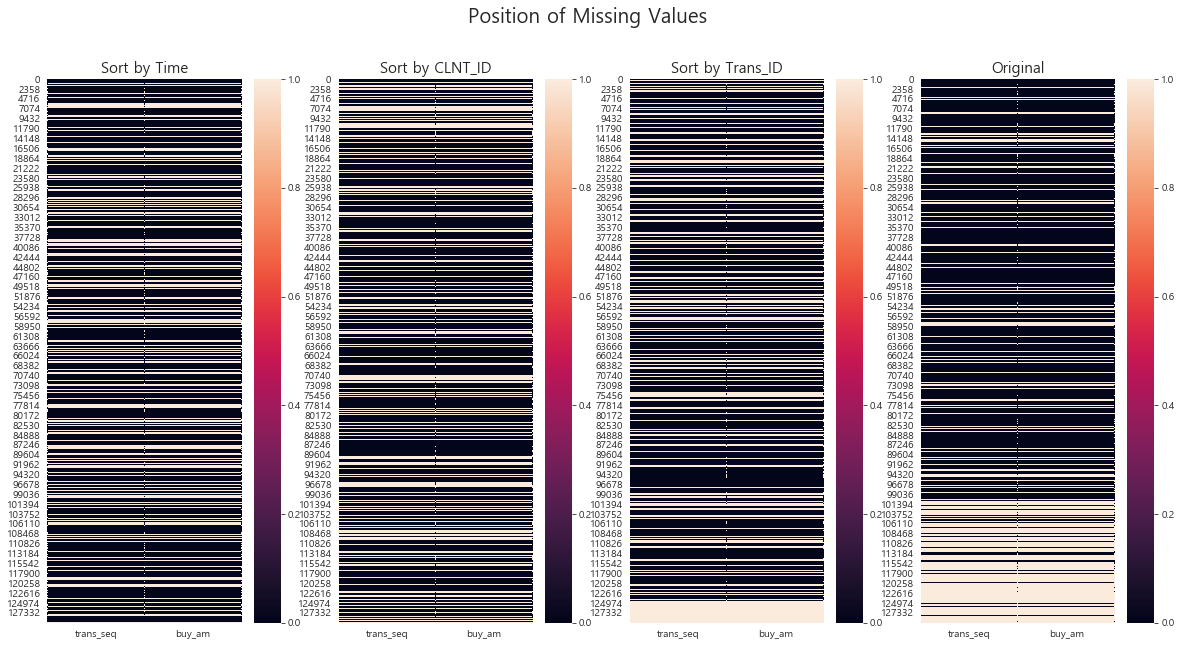

In [78]:
fig, ax = plt.subplots(ncols=4, figsize = (20, 10))
sns.heatmap(sub_df2.sort_values(by = "time")[["trans_seq","buy_am"]].reset_index(drop=True).isnull(), ax = ax[0])
sns.heatmap(sub_df2.sort_values(by = "clnt_id")[["trans_seq","buy_am"]].reset_index(drop=True).isnull(), ax = ax[1])
sns.heatmap(sub_df2.sort_values(by = "trans_id")[["trans_seq","buy_am"]].reset_index(drop=True).isnull(), ax = ax[2])
sns.heatmap(sub_df2[["trans_seq","buy_am"]].isnull(), ax = ax[3])

plt.suptitle("Position of Missing Values", fontsize = 20)
ax[0].set_title("Sort by Time", fontsize = 15)
ax[1].set_title("Sort by CLNT_ID", fontsize = 15)
ax[2].set_title("Sort by Trans_ID", fontsize = 15)
ax[3].set_title("Original", fontsize = 15)

Text(0.5, 1.0, 'Original')

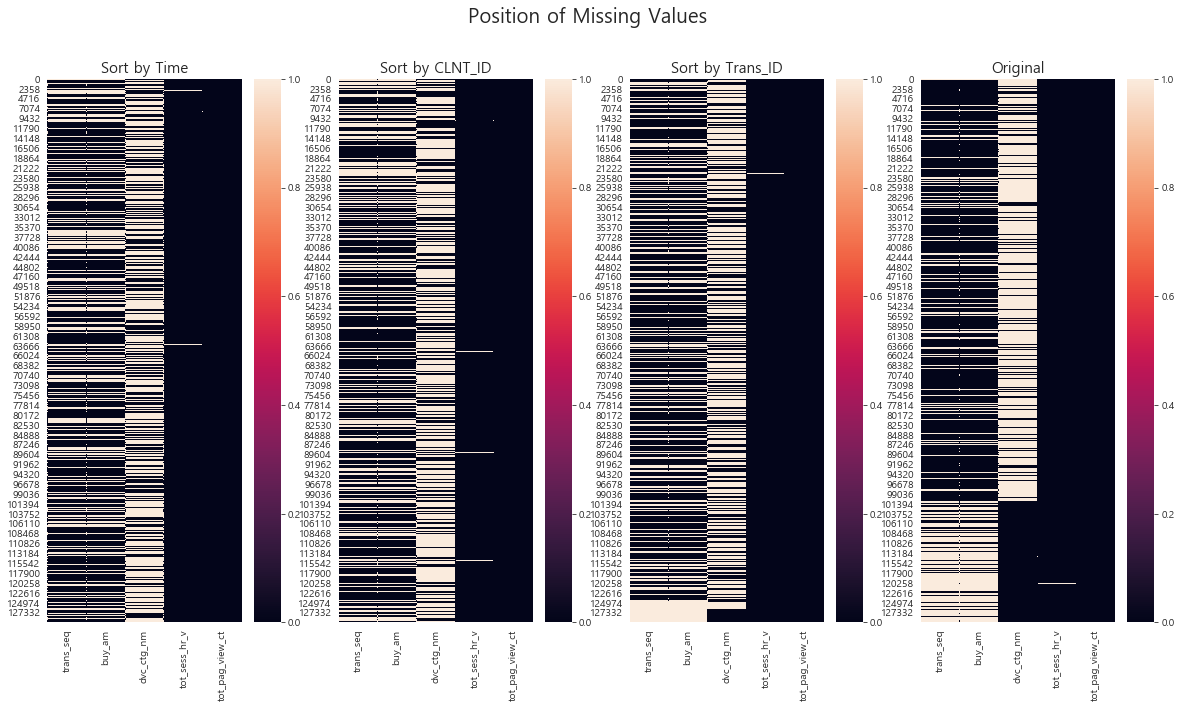

In [81]:
fig, ax = plt.subplots(ncols=4, figsize = (20, 10))
sns.heatmap(sub_df2.sort_values(by = "time")[["trans_seq","buy_am","dvc_ctg_nm","tot_sess_hr_v","tot_pag_view_ct"]].reset_index(drop=True).isnull(), ax = ax[0])
sns.heatmap(sub_df2.sort_values(by = "clnt_id")[["trans_seq","buy_am","dvc_ctg_nm","tot_sess_hr_v","tot_pag_view_ct"]].reset_index(drop=True).isnull(), ax = ax[1])
sns.heatmap(sub_df2.sort_values(by = "trans_id")[["trans_seq","buy_am","dvc_ctg_nm","tot_sess_hr_v","tot_pag_view_ct"]].reset_index(drop=True).isnull(), ax = ax[2])
sns.heatmap(sub_df2[["trans_seq","buy_am","dvc_ctg_nm","tot_sess_hr_v","tot_pag_view_ct"]].isnull(), ax = ax[3])

plt.suptitle("Position of Missing Values", fontsize = 20)
ax[0].set_title("Sort by Time", fontsize = 15)
ax[1].set_title("Sort by CLNT_ID", fontsize = 15)
ax[2].set_title("Sort by Trans_ID", fontsize = 15)
ax[3].set_title("Original", fontsize = 15)

* Missing Value가 생기는데 뚜렷한 패턴이 있지는 않은것처럼 보임  
  따라서 다른 처리를 하지 않고 합쳐도 될듯 함

In [76]:
online_with_trans = pd.concat([sub_df1, sub_df2], sort=False).reset_index(drop = True)

In [77]:
online_with_trans.sort_values(by = ["clnt_id","time", "hit_seq"], inplace = True)
online_with_trans.reset_index(drop = True, inplace=True)

In [78]:
del [sub_df1, sub_df2]
gc.collect()

332

In [19]:
%whos DataFrame

Variable            Type         Data/Info
------------------------------------------
cust_df             DataFrame           clnt_id clnt_gende<...>n[72399 rows x 3 columns]
item_df             DataFrame          pd_c               <...>\n[1667 rows x 4 columns]
online_df           DataFrame             clnt_id  sess_id<...>196362 rows x 21 columns]
online_with_trans   DataFrame             clnt_id  sess_id<...>269795 rows x 25 columns]
trans_df            DataFrame            clnt_id  trans_id<...>599961 rows x 16 columns]


In [34]:
online_with_trans.loc[:,["trans_seq","pd_c","buy_am","buy_ct"]] = online_with_trans.loc[:,["trans_seq","pd_c",'buy_am',"buy_ct"]].fillna(0).replace("unknown", -1)

In [81]:
merged_online_df = online_with_trans.merge(cust_df, how = "left", on = "clnt_id")

In [86]:
merged_online_df.pd_c = np.where(merged_online_df.pd_c.isnull(),-1,
                           np.where(merged_online_df.pd_c == "unknown",0, merged_online_df.pd_c))

In [100]:
merged_online_df.loc[:,["trans_seq","pd_c","buy_am","buy_ct"]] = merged_online_df.loc[:,["trans_seq","pd_c",'buy_am',"buy_ct"]].fillna(-1).replace("unknown", 0)

In [92]:
item_df.dtypes

pd_c         int16
clac_nm1    object
clac_nm2    object
clac_nm3    object
dtype: object

In [94]:
merged_online_df.pd_c = merged_online_df.pd_c.astype(np.int16)

In [97]:
merged_online_df = merged_online_df.merge(item_df, how = "left", on = "pd_c")

In [ ]:
merged_online_df.loc[:,["trans_seq","pd_c","buy_am","buy_ct"]] = merged_online_df.loc[:,["trans_seq","pd_c",'buy_am',"buy_ct"]].fillna(0).replace("unknown", -1)

In [101]:
merged_online_df.to_csv("merged_onilne_df.csv", index = False)

In [106]:
merged_online_df.clac_nm1.value_counts()

Vegetables                                   11243
Meats                                         8103
Substitute Foods                              8093
Snack Foods                                   7594
Dairy Products                                7496
Chilled Foods                                 7485
Frozen Foods                                  5971
Fruits                                        5369
Beverages                                     5341
Spices / Seasonings                           3545
Detergents / Hygiene Goods                    2414
Canned / Jarred Foods                         1805
Women's Clothing                              1451
Dried Sea Foods                               1248
Personal Care                                 1172
Sea Foods                                      889
Grains                                         753
Fashion Accessories                            749
Cosmetics / Beauty Care                        692
Coffee / Tea                   

In [54]:
online_df = pd.read_csv("merged_onilne_df.csv")

In [57]:
online_df.loc[:,"hit_pss_tm"] = online_df.hit_pss_tm // 1000

In [3]:
online_df.isnull().sum()

clnt_id                  0
sess_id                  0
hit_seq                  0
action_type              0
biz_unit                 0
sess_dt                  0
hit_tm                   0
hit_pss_tm               0
trans_id           3139373
sech_kwd           2618157
tot_pag_view_ct       1428
tot_sess_hr_v        57607
trfc_src                 0
dvc_ctg_nm         1840409
time                     0
year                     0
month                    0
day                      0
weekday                  0
hour                     0
min                      0
trans_seq                0
pd_c                     0
buy_am                   0
buy_ct                   0
clnt_gender              0
clnt_age                 0
clac_nm1           3183142
clac_nm2           3183142
clac_nm3           3183147
dtype: int64

Mean of NA in each column
* trans_id : action_type != 6,7 인 경우 => 0으로 대체
* sech_kwd : action_type != 0 인 경우 => "" 로 대체
* tot_pag_view_ct : => 1로 대체
* tot_sess_hr_v : => max hit_pss_tm == 0 ( 1초 이하 ) 인경우 1로 대체, >= 1 인경우 max hit_pss_tm값으로 대체
* dvc_ctg_nm : 어떤 접속기기인지 모름 => unknown으로 대체
* clac_nm1,2,3 : pd_c가 unknown이거나 trans_id가 없는 경우 / pd_c가 unknown인 경우 unknown으로 대체, trans_id가 없는 경우 공백으로 대체

In [62]:
online_df.loc[online_df.trans_id.isnull(),"trans_id"] = 0
online_df.loc[online_df.sech_kwd.isnull(),"sech_kwd"] = ""
online_df.loc[online_df.tot_pag_view_ct.isnull(),"tot_pag_view_ct"] = 1
online_df.loc[online_df.tot_sess_hr_v.isnull(),"tot_sess_hr_v"] = np.where(online_df[online_df.tot_sess_hr_v.isnull()].hit_pss_tm == 0,
                                                                               1, online_df[online_df.tot_sess_hr_v.isnull()].hit_pss_tm)
online_df.loc[online_df.dvc_ctg_nm.isnull(),"dvc_ctg_nm"] = "unknown"
online_df.loc[online_df.clac_nm1.isnull(),"clac_nm1"] = ""
online_df.loc[online_df.clac_nm2.isnull(),"clac_nm2"] = ""
online_df.loc[online_df.clac_nm3.isnull(),"clac_nm3"] = ""

In [66]:
online_df.to_csv("clear_merged_online_df.csv", index = False)

In [114]:
online_df = pd.read_csv("clear_merged_online_df.csv")

In [100]:
trans_df.drop(["de_dt","de_tm"], axis=1, inplace= True)

In [116]:
online_df

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,time,year,month,day,weekday,hour,min,trans_seq,pd_c,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm1,clac_nm2,clac_nm3
0,1,1,1,0,A01,20190911,16:14,11,0.0,과일선물세트,14.0,124.0,unknown,mobile_app,2019-09-11 16:14:00,2019,9,11,2,16,14,-1.0,-1,-1.0,-1.0,unknown,unknown,NaN,NaN,NaN
1,1,1,2,0,A01,20190911,16:15,22,0.0,과일선물세트 백화점,14.0,124.0,unknown,mobile_app,2019-09-11 16:15:00,2019,9,11,2,16,15,-1.0,-1,-1.0,-1.0,unknown,unknown,NaN,NaN,NaN
2,1,1,3,0,A01,20190911,16:15,36,0.0,과일바구니,14.0,124.0,unknown,mobile_app,2019-09-11 16:15:00,2019,9,11,2,16,15,-1.0,-1,-1.0,-1.0,unknown,unknown,NaN,NaN,NaN
3,1,2,1,0,A01,20190922,14:09,41,0.0,초등가을잠바,45.0,424.0,unknown,mobile_app,2019-09-22 14:09:00,2019,9,22,6,14,9,-1.0,-1,-1.0,-1.0,unknown,unknown,NaN,NaN,NaN
4,1,2,2,0,A01,20190922,14:10,56,0.0,초등가을점퍼,45.0,424.0,unknown,mobile_app,2019-09-22 14:10:00,2019,9,22,6,14,10,-1.0,-1,-1.0,-1.0,unknown,unknown,NaN,NaN,NaN
5,1,2,3,0,A01,20190922,14:10,70,0.0,초등남아옷,45.0,424.0,unknown,mobile_app,2019-09-22 14:10:00,2019,9,22,6,14,10,-1.0,-1,-1.0,-1.0,unknown,unknown,NaN,NaN,NaN
6,1,2,4,0,A01,20190922,14:11,119,0.0,초등남아점퍼,45.0,424.0,unknown,mobile_app,2019-09-22 14:11:00,2019,9,22,6,14,11,-1.0,-1,-1.0,-1.0,unknown,unknown,NaN,NaN,NaN
7,1,2,5,0,A01,20190922,14:11,162,0.0,노스페이스키즈,45.0,424.0,unknown,mobile_app,2019-09-22 14:11:00,2019,9,22,6,14,11,-1.0,-1,-1.0,-1.0,unknown,unknown,NaN,NaN,NaN
8,1,2,6,0,A01,20190922,14:12,178,0.0,노스페이스초등,45.0,424.0,unknown,mobile_app,2019-09-22 14:12:00,2019,9,22,6,14,12,-1.0,-1,-1.0,-1.0,unknown,unknown,NaN,NaN,NaN
9,1,2,7,0,A01,20190922,14:12,192,0.0,노스페이스키즈,45.0,424.0,unknown,mobile_app,2019-09-22 14:12:00,2019,9,22,6,14,12,-1.0,-1,-1.0,-1.0,unknown,unknown,NaN,NaN,NaN


In [115]:
online_df[online_df.action_type == 7].merge(trans_df, how = "left", on = ["clnt_id","trans_id"])

,clnt_id,sess_id,hit_seq,action_type,biz_unit_x,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,time_x,year_x,month_x,day_x,weekday_x,hour_x,min_x,trans_seq_x,pd_c_x,buy_am_x,buy_ct_x,clnt_gender,clnt_age,clac_nm1,clac_nm2,clac_nm3,trans_seq_y,biz_unit_y,pd_c_y,buy_am_y,buy_ct_y,time_y,year_y,month_y,day_y,weekday_y,hour_y,min_y
0,49,9,55,7,A03,20190717,11:04,1906,52688.0,NaN,73.0,2290.0,PUSH,unknown,2019-07-17 11:04:00,2019,7,17,2,11,4,-1.0,-1,-1.0,-1.0,F,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,80,2,1,7,A02,20190706,21:32,32,42579.0,NaN,9.0,125.0,unknown,mobile_app,2019-07-06 21:32:00,2019,7,6,5,21,32,-1.0,-1,-1.0,-1.0,F,50,NaN,NaN,NaN,2.0,A02,unknown,0.0,1.0,2019-07-04 23:34:00,2019.0,7.0,4.0,3.0,23.0,34.0
2,80,2,1,7,A02,20190706,21:32,32,42579.0,NaN,9.0,125.0,unknown,mobile_app,2019-07-06 21:32:00,2019,7,6,5,21,32,-1.0,-1,-1.0,-1.0,F,50,NaN,NaN,NaN,1.0,A02,1558,147100.0,1.0,2019-07-04 23:34:00,2019.0,7.0,4.0,3.0,23.0,34.0
3,80,2,2,7,A02,20190706,21:32,46,42579.0,NaN,9.0,125.0,unknown,mobile_app,2019-07-06 21:32:00,2019,7,6,5,21,32,-1.0,-1,-1.0,-1.0,F,50,NaN,NaN,NaN,2.0,A02,unknown,0.0,1.0,2019-07-04 23:34:00,2019.0,7.0,4.0,3.0,23.0,34.0
4,80,2,2,7,A02,20190706,21:32,46,42579.0,NaN,9.0,125.0,unknown,mobile_app,2019-07-06 21:32:00,2019,7,6,5,21,32,-1.0,-1,-1.0,-1.0,F,50,NaN,NaN,NaN,1.0,A02,1558,147100.0,1.0,2019-07-04 23:34:00,2019.0,7.0,4.0,3.0,23.0,34.0
5,80,2,3,7,A02,20190706,21:33,90,42579.0,NaN,9.0,125.0,unknown,mobile_app,2019-07-06 21:33:00,2019,7,6,5,21,33,-1.0,-1,-1.0,-1.0,F,50,NaN,NaN,NaN,2.0,A02,unknown,0.0,1.0,2019-07-04 23:34:00,2019.0,7.0,4.0,3.0,23.0,34.0
6,80,2,3,7,A02,20190706,21:33,90,42579.0,NaN,9.0,125.0,unknown,mobile_app,2019-07-06 21:33:00,2019,7,6,5,21,33,-1.0,-1,-1.0,-1.0,F,50,NaN,NaN,NaN,1.0,A02,1558,147100.0,1.0,2019-07-04 23:34:00,2019.0,7.0,4.0,3.0,23.0,34.0
7,80,2,4,7,A02,20190706,21:34,121,42579.0,NaN,9.0,125.0,unknown,mobile_app,2019-07-06 21:34:00,2019,7,6,5,21,34,-1.0,-1,-1.0,-1.0,F,50,NaN,NaN,NaN,2.0,A02,unknown,0.0,1.0,2019-07-04 23:34:00,2019.0,7.0,4.0,3.0,23.0,34.0
8,80,2,4,7,A02,20190706,21:34,121,42579.0,NaN,9.0,125.0,unknown,mobile_app,2019-07-06 21:34:00,2019,7,6,5,21,34,-1.0,-1,-1.0,-1.0,F,50,NaN,NaN,NaN,1.0,A02,1558,147100.0,1.0,2019-07-04 23:34:00,2019.0,7.0,4.0,3.0,23.0,34.0
9,80,4,10,7,A02,20190710,19:37,2376,47830.0,NaN,42.0,2640.0,unknown,mobile_app,2019-07-10 19:37:00,2019,7,10,2,19,37,-1.0,-1,-1.0,-1.0,F,50,NaN,NaN,NaN,1.0,A02,1304,49000.0,1.0,2019-07-10 19:27:00,2019.0,7.0,10.0,2.0,19.0,27.0


In [113]:
online_df[(online_df.clnt_id==80) & (online_df.action_type.isin([6,7]))]

,clnt_id,sess_id,hit_seq,action_type,biz_unit,sess_dt,hit_tm,hit_pss_tm,trans_id,sech_kwd,tot_pag_view_ct,tot_sess_hr_v,trfc_src,dvc_ctg_nm,time,year,month,day,weekday,hour,min,trans_seq,pd_c,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm1,clac_nm2,clac_nm3
3888,80,1,14,6,A02,20190704,23:34,1336,42579.0,NaN,16.0,1349.0,unknown,mobile_app,2019-07-04 23:34:00,2019,7,4,3,23,34,2.0,0,0.0,1.0,F,50,NaN,NaN,NaN
3889,80,1,14,6,A02,20190704,23:34,1336,42579.0,NaN,16.0,1349.0,unknown,mobile_app,2019-07-04 23:34:00,2019,7,4,3,23,34,1.0,1558,147100.0,1.0,F,50,Underwear / Socks and Hosiery / Homewear,Women's Underwear,Women's Underwear Sets
3890,80,1,15,6,A02,20190704,23:34,1349,0.0,NaN,16.0,1349.0,unknown,mobile_app,2019-07-04 23:34:00,2019,7,4,3,23,34,-1.0,-1,-1.0,-1.0,F,50,NaN,NaN,NaN
3891,80,2,1,7,A02,20190706,21:32,32,42579.0,NaN,9.0,125.0,unknown,mobile_app,2019-07-06 21:32:00,2019,7,6,5,21,32,-1.0,-1,-1.0,-1.0,F,50,NaN,NaN,NaN
3892,80,2,2,7,A02,20190706,21:32,46,42579.0,NaN,9.0,125.0,unknown,mobile_app,2019-07-06 21:32:00,2019,7,6,5,21,32,-1.0,-1,-1.0,-1.0,F,50,NaN,NaN,NaN
3893,80,2,3,7,A02,20190706,21:33,90,42579.0,NaN,9.0,125.0,unknown,mobile_app,2019-07-06 21:33:00,2019,7,6,5,21,33,-1.0,-1,-1.0,-1.0,F,50,NaN,NaN,NaN
3894,80,2,4,7,A02,20190706,21:34,121,42579.0,NaN,9.0,125.0,unknown,mobile_app,2019-07-06 21:34:00,2019,7,6,5,21,34,-1.0,-1,-1.0,-1.0,F,50,NaN,NaN,NaN
3899,80,4,4,6,A02,20190710,19:00,119,47815.0,NaN,42.0,2640.0,unknown,mobile_app,2019-07-10 19:00:00,2019,7,10,2,19,0,1.0,1307,39000.0,1.0,F,50,Sport Fashion,Women's General Sport Clothing,Women's Sport T-Shirts / Tops
3904,80,4,9,6,A02,20190710,19:27,1747,47830.0,NaN,42.0,2640.0,unknown,mobile_app,2019-07-10 19:27:00,2019,7,10,2,19,27,1.0,1304,49000.0,1.0,F,50,Sport Fashion,Women's General Sport Clothing,Women's General Sport Pants
3905,80,4,10,7,A02,20190710,19:37,2376,47830.0,NaN,42.0,2640.0,unknown,mobile_app,2019-07-10 19:37:00,2019,7,10,2,19,37,-1.0,-1,-1.0,-1.0,F,50,NaN,NaN,NaN


In [110]:
trans_df[trans_df.clnt_id == 2]

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,buy_am,buy_ct,time,year,month,day,weekday,hour,min
38663,2,65505,1,A03,0092,9000,5,2019-08-01 22:00:00,2019,8,1,3,22,0
107151,2,64691,5,A03,0092,1800,1,2019-07-31 21:25:00,2019,7,31,2,21,25
107209,2,64691,2,A03,0151,3990,1,2019-07-31 21:25:00,2019,7,31,2,21,25
113315,2,64691,3,A03,0351,4690,1,2019-07-31 21:25:00,2019,7,31,2,21,25
114604,2,62037,1,A03,0092,36000,20,2019-07-29 23:47:00,2019,7,29,0,23,47
118651,2,64691,4,A03,0189,4290,1,2019-07-31 21:25:00,2019,7,31,2,21,25
118652,2,64691,1,A03,0186,3790,1,2019-07-31 21:25:00,2019,7,31,2,21,25
161802,2,88495,2,A03,1395,2850,1,2019-08-30 22:00:00,2019,8,30,4,22,0
161803,2,88495,3,A03,1395,5700,2,2019-08-30 22:00:00,2019,8,30,4,22,0
161808,2,88495,1,A03,1395,3590,1,2019-08-30 22:00:00,2019,8,30,4,22,0
